In [1]:


# This is lzl's snippet for diploma project
import math
import os,shutil
import random
import warnings
import gc

import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import seaborn as sns
from shapely.geometry import LineString, Point, Polygon
from shapely.wkt import dumps, loads
from tqdm import tqdm

import traProject as tp
from traProject.analysisFuns import statisticFuns as sfuns
from traProject.basicFuns import CalFuns as cfun,VisFuns as vfun,DataProcessingFuns as dfun
from traProject.classificationFuns import models
import traProject.utils as tu

random.seed(1229)

tqdm.pandas(desc='pandas bar')

plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

warnings.filterwarnings("ignore")

# 问题校正
原始数据以下字段需要处理
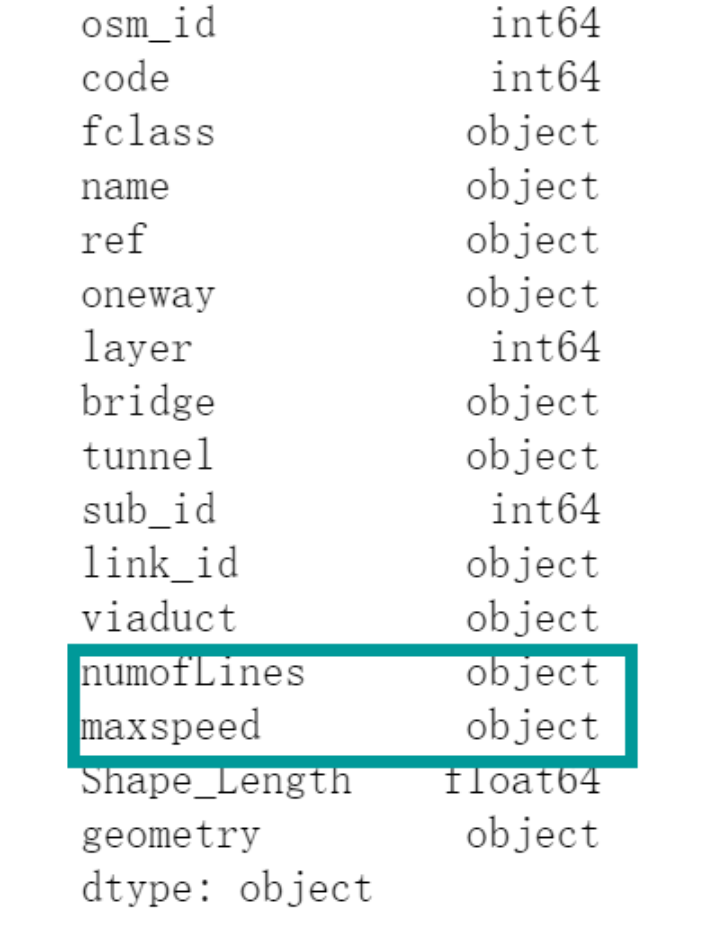

# 原始路段

In [2]:
rpath='../../output/paper/wuhan_road/WUHAN.csv'#路网文件数据路径
rv0=pd.read_csv(rpath)
rv0['maxspeed0']=rv0['maxspeed']#maxspeed0 为原始限速字段，处理后的保留在maxspeed字段
rv0=tu.dfReC(rv0,'maxspeed0',13)
rv0

,osm_id,code,fclass,name,ref,oneway,layer,bridge,tunnel,sub_id,link_id,viaduct,numofLines,maxspeed0,maxspeed,Shape_Length,geometry
0,27402443,5112,trunk,白沙洲長江大橋,,F,1,T,F,1,27402443-1,F,3,"80,60","80,60",0.026617,MULTILINESTRING ((114.2505254 30.4808406999999...
1,28833560,5114,secondary,京汉大道,,F,0,F,F,1,28833560-1,T,1,40,40,0.001235,MULTILINESTRING ((114.2631678 30.5790225999999...
2,28833560,5114,secondary,京汉大道,,F,0,F,F,2,28833560-2,T,3,50,50,0.001886,MULTILINESTRING ((114.2620637000001 30.5785846...
3,28833560,5114,secondary,京汉大道,,F,0,F,F,3,28833560-3,T,2,50,50,0.000667,MULTILINESTRING ((114.2603591 30.5777792000001...
4,28833560,5114,secondary,京汉大道,,F,0,F,F,4,28833560-4,T,2,50,50,0.004035,MULTILINESTRING ((114.2597435 30.5775230000001...
5,28833560,5114,secondary,京汉大道,,F,0,F,F,6,28833560-6,T,2,40,40,0.007707,MULTILINESTRING ((114.2558672 30.5761832000000...
6,28833560,5114,secondary,京汉大道,,F,0,F,F,7,28833560-7,T,2,40,40,0.002076,MULTILINESTRING ((114.2483434 30.5745228000000...
7,28833560,5114,secondary,京汉大道,,F,0,F,F,8,28833560-8,T,2,40,40,0.000223,MULTILINESTRING ((114.2462904000001 30.5742136...
8,28907665,5115,tertiary,玫瑰街,,B,0,F,F,1,28907665-1,F,3,40,40,0.000923,MULTILINESTRING ((114.2156101 30.5671396999999...
9,28907665,5115,tertiary,玫瑰街,,B,0,F,F,2,28907665-2,F,4,40,40,0.006954,MULTILINESTRING ((114.2147211 30.5673895000000...


# 生成校准文件，人工校正

In [3]:
# 生成校准文件
# ms=rv0.copy()
# ms['flag']=0
# for i in range(len(ms)):
#     row=ms.iloc[i,:]
#     if len(row.maxspeed)!=2:
#         ms.loc[i,'flag']=1
# wlist=ms[ms['flag']==1]
# gs=wlist.groupby('maxspeed')
# wv=[]
# for name,g in gs:
#     wv.append(name)
# correctList=pd.DataFrame(wv,columns=['old'])
# correctList['new']=0
# correctList.to_csv('../../output/paper/wuhan_road/maxspeed_fit.csv',encoding='utf-8-sig',index=0)#在文件中人工修正

# 利用校准文件校正数据

In [4]:
clist=pd.read_csv('../../output/paper/wuhan_road/maxspeed_fit1.csv')#-1为不考虑的
clist

,old,new
0,60≤x≤40,-1
1,"70,40(下桥有一部分因维修为限速40)",-1
2,"70,60",-1
3,"70≤X≤80,70≤X≤80,50≤X≤70",-1
4,"80,60",-1
5,"80,80,60",-1
6,"F30,T20",-1
7,"F40,T50",-1
8,"T30,F40",-1
9,"T40,F30",-1


In [5]:
for idx in range(len(clist)):
    co=clist.loc[idx,'old']
    cn=clist.loc[idx,'new']
    rv0.loc[rv0.maxspeed0==co,'maxspeed']=cn
rv0.maxspeed=rv0.maxspeed.astype(int)
rv0=rv0[rv0.maxspeed>0]
rv0=rv0.reset_index(drop=True)
rv0.numofLines=rv0.numofLines.apply(lambda x:int(x[0]))#处理车道数
rv0=tu.cutBZ(rv0,clist=['oneway','bridge','tunnel','viaduct'])
#viaduct 修正
rv0.loc[rv0.viaduct==' ','viaduct']='F'

# 线型特征计算

In [6]:
rv0['Sdis']=rv0['geometry'].apply(lambda x:loads(x).length)#曲线长
rv0['Xdis']=rv0['geometry'].apply(tu.calXdis)#直线长
rv0['RC']=rv0['Sdis']/rv0['Xdis']#弯曲度

# 输出

In [7]:
rv0.to_csv('../../output/paper/wuhan_road/WUHAN_new1.csv',index=0,encoding='utf-8-sig')